# Principal Component Analysis (PCA) on Breast Cancer Dataset

This notebook implements Principal Component Analysis for dimensionality reduction on the breast cancer dataset and visualizes the results with various plots and performance metrics.

In [6]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, roc_auc_score)
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Load and Explore the Dataset

In [7]:
# Load the breast cancer dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Create DataFrame for better visualization
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

print("Dataset Information:")
print(f"Shape: {df.shape}")
print(f"Features: {len(data.feature_names)}")
print(f"Classes: {data.target_names}")
print(f"Class distribution:")
print(pd.Series(y).value_counts().sort_index())

# Display feature groups
print("\nFeature Groups:")
feature_groups = {
    'Mean': [col for col in data.feature_names if 'mean' in col],
    'Standard Error': [col for col in data.feature_names if 'error' in col],
    'Worst': [col for col in data.feature_names if 'worst' in col]
}

for group, features in feature_groups.items():
    print(f"{group}: {len(features)} features")
    print(f"  {features[:3]}...")  # Show first 3 features

print(f"\nFeature statistics:")
print(df.describe().iloc[:, :5])  # Show first 5 features

Dataset Information:
Shape: (569, 31)
Features: 30
Classes: ['malignant' 'benign']
Class distribution:
0    212
1    357
Name: count, dtype: int64

Feature Groups:
Mean: 10 features
  [np.str_('mean radius'), np.str_('mean texture'), np.str_('mean perimeter')]...
Standard Error: 10 features
  [np.str_('radius error'), np.str_('texture error'), np.str_('perimeter error')]...
Worst: 10 features
  [np.str_('worst radius'), np.str_('worst texture'), np.str_('worst perimeter')]...

Feature statistics:
       mean radius  mean texture  mean perimeter    mean area  mean smoothness
count   569.000000    569.000000      569.000000   569.000000       569.000000
mean     14.127292     19.289649       91.969033   654.889104         0.096360
std       3.524049      4.301036       24.298981   351.914129         0.014064
min       6.981000      9.710000       43.790000   143.500000         0.052630
25%      11.700000     16.170000       75.170000   420.300000         0.086370
50%      13.370000     1

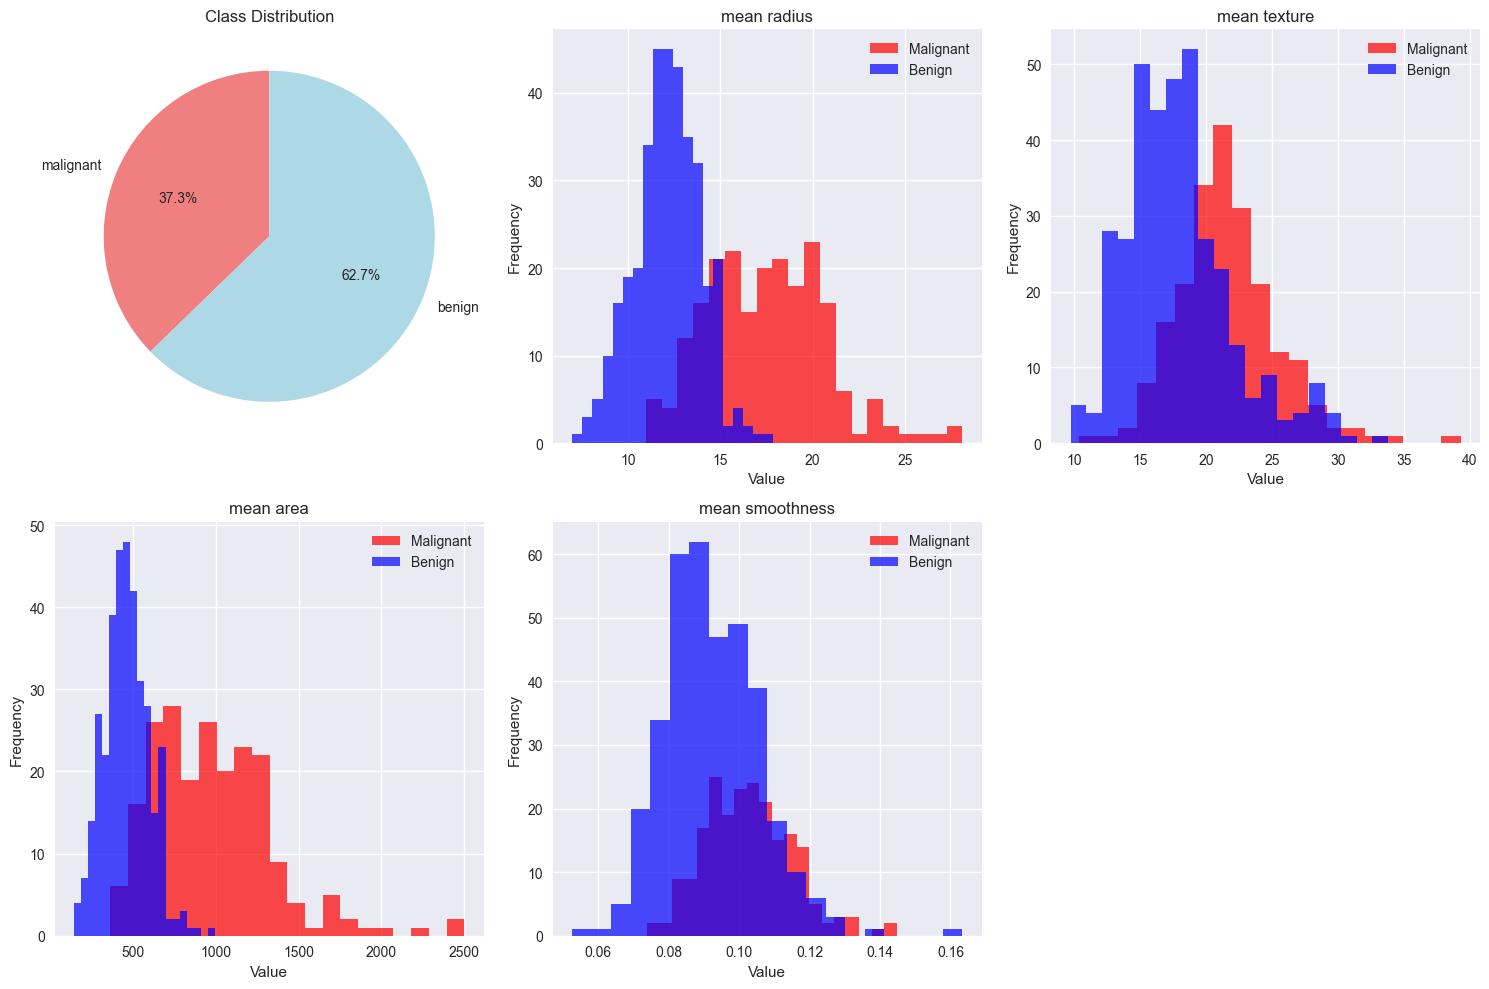

Malignant (0): 212 samples (37.3%)
Benign (1): 357 samples (62.7%)


In [8]:
# Visualize data distribution and correlation
plt.figure(figsize=(15, 10))

# Class distribution
plt.subplot(2, 3, 1)
class_counts = pd.Series(y).value_counts().sort_index()
colors = ['lightcoral', 'lightblue']
plt.pie(class_counts.values, labels=data.target_names, autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Class Distribution')

# Feature distributions for key features
key_features = ['mean radius', 'mean texture', 'mean area', 'mean smoothness']

for i, feature in enumerate(key_features, 2):
    plt.subplot(2, 3, i)
    
    # Get feature index
    feature_idx = list(data.feature_names).index(feature)
    
    # Plot distributions for each class
    malignant_data = X[y == 0, feature_idx]
    benign_data = X[y == 1, feature_idx]
    
    plt.hist(malignant_data, alpha=0.7, label='Malignant', bins=20, color='red')
    plt.hist(benign_data, alpha=0.7, label='Benign', bins=20, color='blue')
    
    plt.title(f'{feature}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

print(f"Malignant (0): {class_counts[0]} samples ({class_counts[0]/len(y)*100:.1f}%)")
print(f"Benign (1): {class_counts[1]} samples ({class_counts[1]/len(y)*100:.1f}%)")

## 2. Data Preprocessing and Standardization

In [9]:
# Data preprocessing
print("Data preprocessing:")
print(f"Original data shape: {X.shape}")
print(f"Missing values: {pd.DataFrame(X).isnull().sum().sum()}")

# Check feature scales
print(f"\nFeature scales before standardization:")
print(f"Min values: {X.min(axis=0)[:5]}")  # First 5 features
print(f"Max values: {X.max(axis=0)[:5]}")  # First 5 features
print(f"Mean values: {X.mean(axis=0)[:5]}")  # First 5 features
print(f"Std values: {X.std(axis=0)[:5]}")  # First 5 features

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize the features (crucial for PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nAfter standardization:")
print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

# Check standardization
print(f"\nStandardized features (first 5):")
print(f"Mean: {X_train_scaled.mean(axis=0)[:5]}")
print(f"Std: {X_train_scaled.std(axis=0)[:5]}")

Data preprocessing:
Original data shape: (569, 30)
Missing values: 0

Feature scales before standardization:
Min values: [6.981e+00 9.710e+00 4.379e+01 1.435e+02 5.263e-02]
Max values: [2.811e+01 3.928e+01 1.885e+02 2.501e+03 1.634e-01]
Mean values: [1.41272917e+01 1.92896485e+01 9.19690334e+01 6.54889104e+02
 9.63602812e-02]
Std values: [3.52095076e+00 4.29725464e+00 2.42776193e+01 3.51604754e+02
 1.40517641e-02]

After standardization:
Training set: (455, 30)
Test set: (114, 30)
Training class distribution: [170 285]
Test class distribution: [42 72]

Standardized features (first 5):
Mean: [-4.31742554e-15  2.24606658e-15 -7.38359313e-16  1.71779562e-16
  5.22695440e-15]
Std: [1. 1. 1. 1. 1.]


## 3. Principal Component Analysis Implementation

In [10]:
# Apply PCA with all components first to analyze variance
pca_full = PCA()
X_train_pca_full = pca_full.fit_transform(X_train_scaled)

# Analyze explained variance
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

print("PCA Analysis:")
print(f"Total features: {X_train_scaled.shape[1]}")
print(f"Total principal components: {len(explained_variance_ratio)}")

# Find number of components for different variance thresholds
for threshold in [0.8, 0.9, 0.95, 0.99]:
    n_components = np.argmax(cumulative_variance_ratio >= threshold) + 1
    print(f"Components needed for {threshold*100}% variance: {n_components}")

print(f"\nFirst 10 components explain {cumulative_variance_ratio[9]:.4f} of variance")
print(f"First 5 components explain {cumulative_variance_ratio[4]:.4f} of variance")
print(f"First 2 components explain {cumulative_variance_ratio[1]:.4f} of variance")

PCA Analysis:
Total features: 30
Total principal components: 30
Components needed for 80.0% variance: 5
Components needed for 90.0% variance: 7
Components needed for 95.0% variance: 10
Components needed for 99.0% variance: 17

First 10 components explain 0.9527 of variance
First 5 components explain 0.8514 of variance
First 2 components explain 0.6336 of variance


## 4. Variance Explained Analysis and Visualization

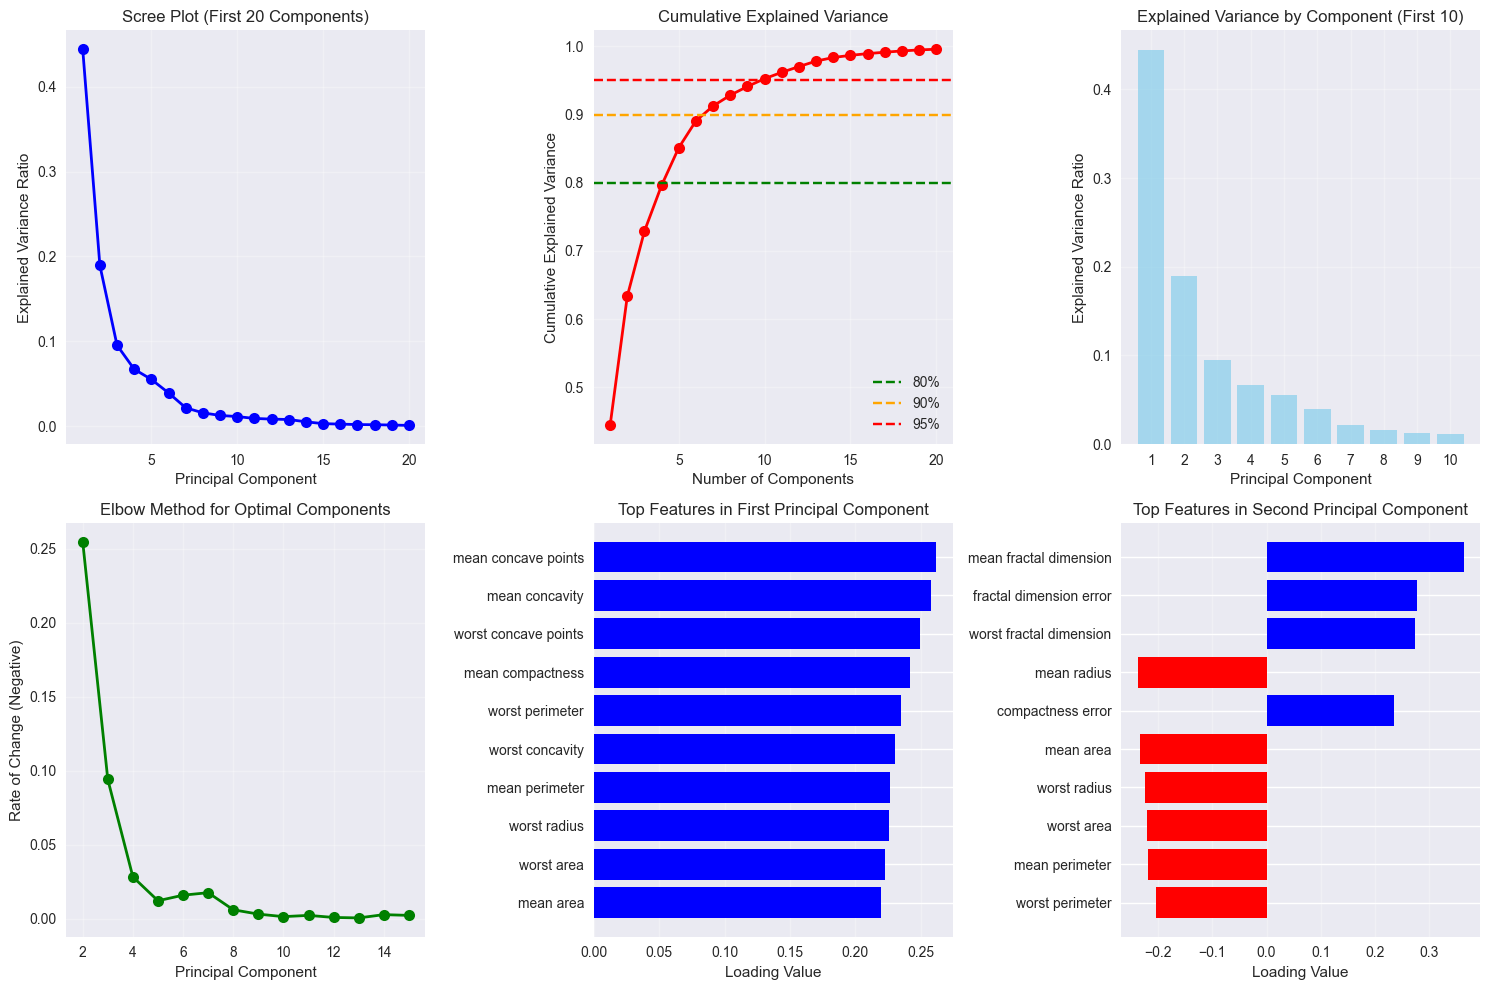

Detailed Variance Analysis:
PC1: 0.4441 (44.41%)
  Cumulative: 0.4441 (44.41%)

PC2: 0.1894 (18.94%)
  Cumulative: 0.6336 (63.36%)

PC3: 0.0954 (9.54%)
  Cumulative: 0.7290 (72.90%)

PC4: 0.0672 (6.72%)
  Cumulative: 0.7963 (79.63%)

PC5: 0.0552 (5.52%)
  Cumulative: 0.8514 (85.14%)

PC6: 0.0393 (3.93%)
  Cumulative: 0.8908 (89.08%)

PC7: 0.0218 (2.18%)
  Cumulative: 0.9126 (91.26%)

PC8: 0.0158 (1.58%)
  Cumulative: 0.9284 (92.84%)

PC9: 0.0128 (1.28%)
  Cumulative: 0.9412 (94.12%)

PC10: 0.0115 (1.15%)
  Cumulative: 0.9527 (95.27%)



In [11]:
# Visualize explained variance
plt.figure(figsize=(15, 10))

# Scree plot
plt.subplot(2, 3, 1)
plt.plot(range(1, 21), explained_variance_ratio[:20], 'bo-', linewidth=2, markersize=8)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot (First 20 Components)')
plt.grid(True, alpha=0.3)

# Cumulative explained variance
plt.subplot(2, 3, 2)
plt.plot(range(1, 21), cumulative_variance_ratio[:20], 'ro-', linewidth=2, markersize=8)
plt.axhline(y=0.8, color='green', linestyle='--', label='80%')
plt.axhline(y=0.9, color='orange', linestyle='--', label='90%')
plt.axhline(y=0.95, color='red', linestyle='--', label='95%')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.grid(True, alpha=0.3)

# Bar plot of first 10 components
plt.subplot(2, 3, 3)
plt.bar(range(1, 11), explained_variance_ratio[:10], color='skyblue', alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Component (First 10)')
plt.xticks(range(1, 11))
plt.grid(True, alpha=0.3)

# Elbow method visualization
plt.subplot(2, 3, 4)
# Calculate the rate of change in explained variance
diff_variance = np.diff(explained_variance_ratio[:15])
plt.plot(range(2, 16), -diff_variance, 'go-', linewidth=2, markersize=8)
plt.xlabel('Principal Component')
plt.ylabel('Rate of Change (Negative)')
plt.title('Elbow Method for Optimal Components')
plt.grid(True, alpha=0.3)

# Feature importance in first PC
plt.subplot(2, 3, 5)
pc1_loadings = pca_full.components_[0]
sorted_idx = np.argsort(np.abs(pc1_loadings))[-10:]  # Top 10 features
top_features = [data.feature_names[i] for i in sorted_idx]
top_loadings = pc1_loadings[sorted_idx]

plt.barh(range(len(top_features)), top_loadings, 
         color=['red' if x < 0 else 'blue' for x in top_loadings])
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Loading Value')
plt.title('Top Features in First Principal Component')
plt.grid(axis='x', alpha=0.3)

# Feature importance in second PC
plt.subplot(2, 3, 6)
pc2_loadings = pca_full.components_[1]
sorted_idx = np.argsort(np.abs(pc2_loadings))[-10:]  # Top 10 features
top_features = [data.feature_names[i] for i in sorted_idx]
top_loadings = pc2_loadings[sorted_idx]

plt.barh(range(len(top_features)), top_loadings, 
         color=['red' if x < 0 else 'blue' for x in top_loadings])
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Loading Value')
plt.title('Top Features in Second Principal Component')
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed variance information
print("Detailed Variance Analysis:")
for i in range(min(10, len(explained_variance_ratio))):
    print(f"PC{i+1}: {explained_variance_ratio[i]:.4f} ({explained_variance_ratio[i]*100:.2f}%)")
    print(f"  Cumulative: {cumulative_variance_ratio[i]:.4f} ({cumulative_variance_ratio[i]*100:.2f}%)")
    print()

## 5. PCA Visualization in 2D and 3D

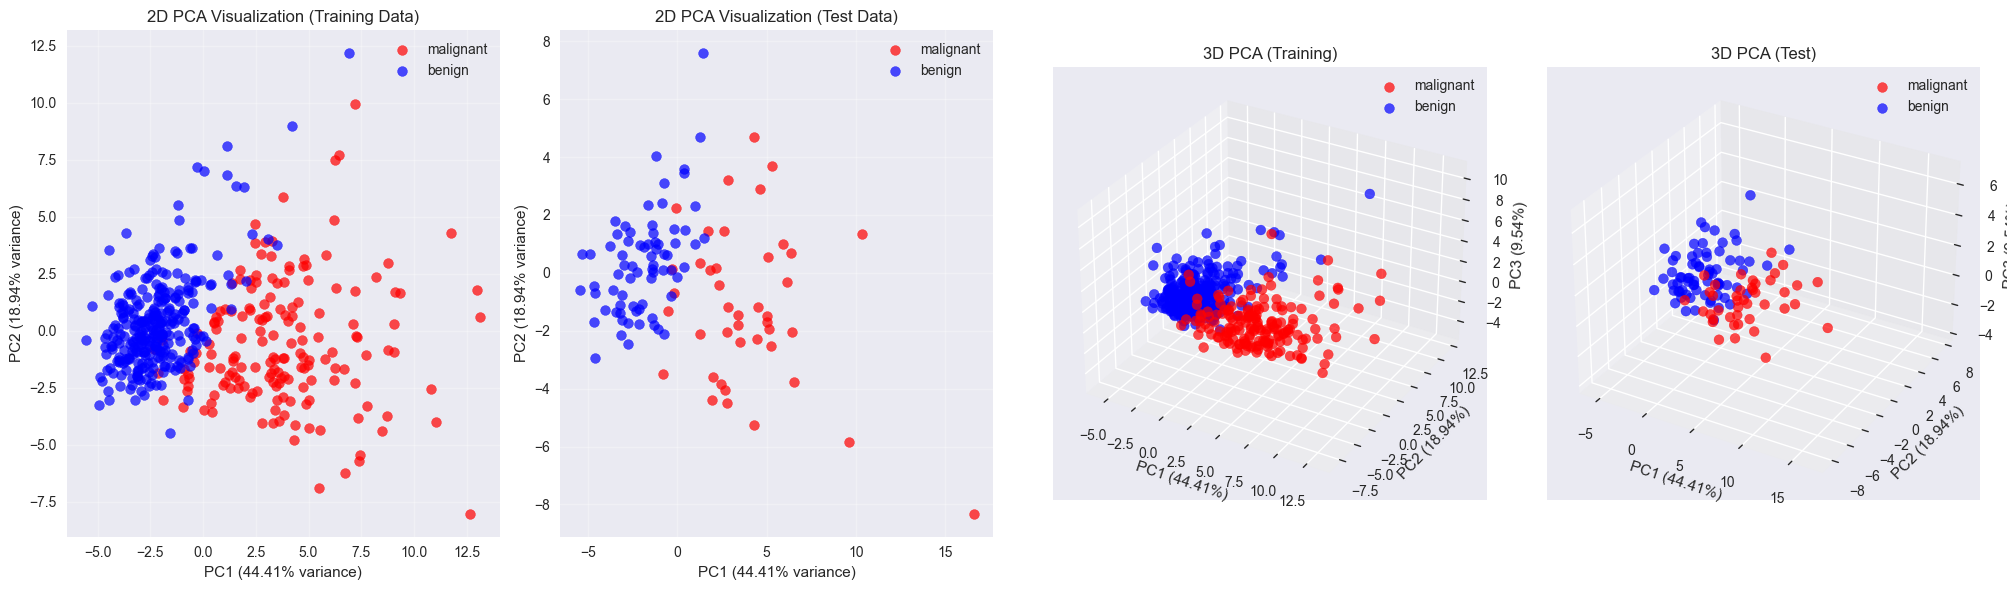

PCA Visualization Summary:
2D PCA explains 0.6336 of total variance
3D PCA explains 0.7290 of total variance
PC1: 0.4441
PC2: 0.1894
PC3: 0.0954


In [12]:
# Create PCA models for 2D and 3D visualization
pca_2d = PCA(n_components=2)
pca_3d = PCA(n_components=3)

X_train_pca_2d = pca_2d.fit_transform(X_train_scaled)
X_test_pca_2d = pca_2d.transform(X_test_scaled)

X_train_pca_3d = pca_3d.fit_transform(X_train_scaled)
X_test_pca_3d = pca_3d.transform(X_test_scaled)

# 2D and 3D visualization
plt.figure(figsize=(20, 6))

# 2D PCA visualization - Training data
plt.subplot(1, 4, 1)
colors = ['red', 'blue']
for i, (color, label) in enumerate(zip(colors, data.target_names)):
    mask = y_train == i
    plt.scatter(X_train_pca_2d[mask, 0], X_train_pca_2d[mask, 1], 
                c=color, label=label, alpha=0.7, s=50)

plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
plt.title('2D PCA Visualization (Training Data)')
plt.legend()
plt.grid(True, alpha=0.3)

# 2D PCA visualization - Test data
plt.subplot(1, 4, 2)
for i, (color, label) in enumerate(zip(colors, data.target_names)):
    mask = y_test == i
    plt.scatter(X_test_pca_2d[mask, 0], X_test_pca_2d[mask, 1], 
                c=color, label=label, alpha=0.7, s=50)

plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
plt.title('2D PCA Visualization (Test Data)')
plt.legend()
plt.grid(True, alpha=0.3)

# 3D PCA visualization - Training data
ax1 = plt.subplot(1, 4, 3, projection='3d')
for i, (color, label) in enumerate(zip(colors, data.target_names)):
    mask = y_train == i
    ax1.scatter(X_train_pca_3d[mask, 0], X_train_pca_3d[mask, 1], X_train_pca_3d[mask, 2],
                c=color, label=label, alpha=0.7, s=50)

ax1.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})')
ax1.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})')
ax1.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})')
ax1.set_title('3D PCA (Training)')
ax1.legend()

# 3D PCA visualization - Test data
ax2 = plt.subplot(1, 4, 4, projection='3d')
for i, (color, label) in enumerate(zip(colors, data.target_names)):
    mask = y_test == i
    ax2.scatter(X_test_pca_3d[mask, 0], X_test_pca_3d[mask, 1], X_test_pca_3d[mask, 2],
                c=color, label=label, alpha=0.7, s=50)

ax2.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})')
ax2.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})')
ax2.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})')
ax2.set_title('3D PCA (Test)')
ax2.legend()

plt.tight_layout()
plt.show()

print("PCA Visualization Summary:")
print(f"2D PCA explains {pca_2d.explained_variance_ratio_.sum():.4f} of total variance")
print(f"3D PCA explains {pca_3d.explained_variance_ratio_.sum():.4f} of total variance")
print(f"PC1: {pca_2d.explained_variance_ratio_[0]:.4f}")
print(f"PC2: {pca_2d.explained_variance_ratio_[1]:.4f}")
print(f"PC3: {pca_3d.explained_variance_ratio_[2]:.4f}")

## 6. Classification Performance with Different Numbers of Components

In [13]:
# Test classification performance with different number of components
def evaluate_pca_performance(n_components_list, classifier_func, classifier_name):
    """Evaluate classification performance with different numbers of PCA components"""
    results = {
        'n_components': [],
        'accuracy': [],
        'roc_auc': [],
        'explained_variance': []
    }
    
    for n_comp in n_components_list:
        # Apply PCA
        pca = PCA(n_components=n_comp)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)
        
        # Train classifier
        clf = classifier_func()
        clf.fit(X_train_pca, y_train)
        
        # Predictions
        y_pred = clf.predict(X_test_pca)
        y_pred_proba = clf.predict_proba(X_test_pca)[:, 1] if hasattr(clf, 'predict_proba') else None
        
        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 0
        explained_var = pca.explained_variance_ratio_.sum()
        
        results['n_components'].append(n_comp)
        results['accuracy'].append(accuracy)
        results['roc_auc'].append(roc_auc)
        results['explained_variance'].append(explained_var)
    
    return results

# Test with different classifiers
component_range = [2, 5, 10, 15, 20, 25, 30]

# Logistic Regression
lr_results = evaluate_pca_performance(
    component_range, 
    lambda: LogisticRegression(random_state=42, max_iter=1000),
    "Logistic Regression"
)

# Random Forest
rf_results = evaluate_pca_performance(
    component_range,
    lambda: RandomForestClassifier(random_state=42, n_estimators=100),
    "Random Forest"
)

# SVM
svm_results = evaluate_pca_performance(
    component_range,
    lambda: SVC(random_state=42, probability=True),
    "SVM"
)

# Baseline performance (no PCA)
print("Baseline Performance (No PCA):")
lr_baseline = LogisticRegression(random_state=42, max_iter=1000)
lr_baseline.fit(X_train_scaled, y_train)
y_pred_baseline = lr_baseline.predict(X_test_scaled)
y_pred_proba_baseline = lr_baseline.predict_proba(X_test_scaled)[:, 1]

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_roc_auc = roc_auc_score(y_test, y_pred_proba_baseline)

print(f"Logistic Regression (All 30 features): Accuracy={baseline_accuracy:.4f}, ROC-AUC={baseline_roc_auc:.4f}")
print()

Baseline Performance (No PCA):
Logistic Regression (All 30 features): Accuracy=0.9825, ROC-AUC=0.9954



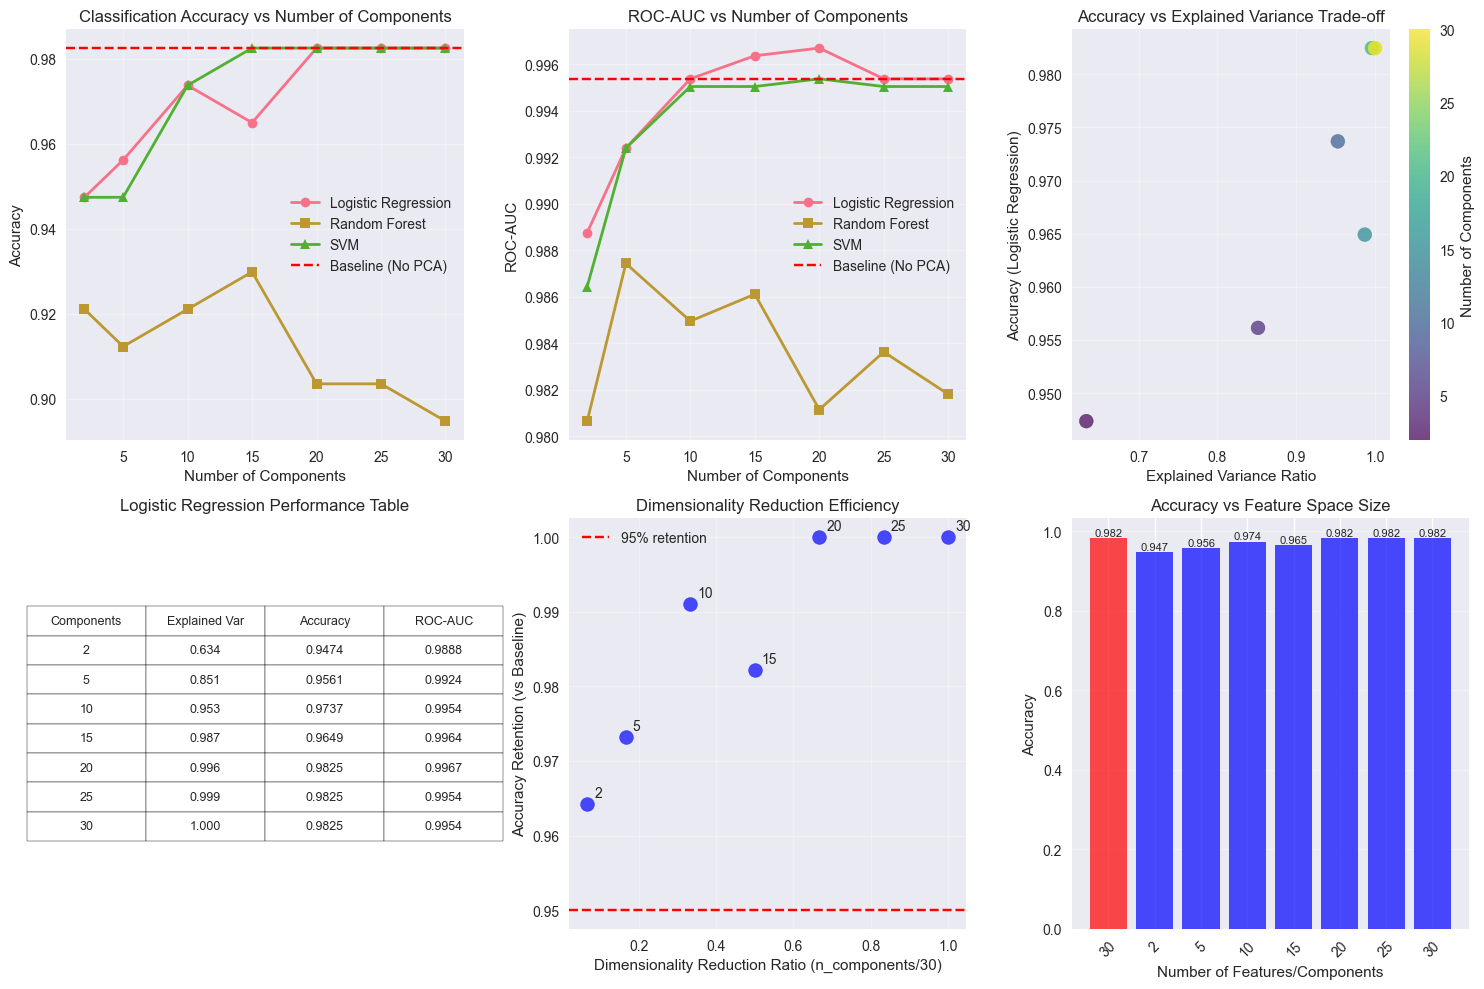

Detailed Results Summary:
Components   Explained Var   LR Acc     RF Acc     SVM Acc   
------------------------------------------------------------
2            0.634           0.9474     0.9211     0.9474    
5            0.851           0.9561     0.9123     0.9474    
10           0.953           0.9737     0.9211     0.9737    
15           0.987           0.9649     0.9298     0.9825    
20           0.996           0.9825     0.9035     0.9825    
25           0.999           0.9825     0.9035     0.9825    
30           1.000           0.9825     0.8947     0.9825    
------------------------------------------------------------
Baseline     1.000           0.9825     N/A        N/A       


In [14]:
# Visualize performance vs number of components
plt.figure(figsize=(15, 10))

# Accuracy comparison
plt.subplot(2, 3, 1)
plt.plot(lr_results['n_components'], lr_results['accuracy'], 'o-', label='Logistic Regression', linewidth=2)
plt.plot(rf_results['n_components'], rf_results['accuracy'], 's-', label='Random Forest', linewidth=2)
plt.plot(svm_results['n_components'], svm_results['accuracy'], '^-', label='SVM', linewidth=2)
plt.axhline(y=baseline_accuracy, color='red', linestyle='--', label='Baseline (No PCA)')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy vs Number of Components')
plt.legend()
plt.grid(True, alpha=0.3)

# ROC-AUC comparison
plt.subplot(2, 3, 2)
plt.plot(lr_results['n_components'], lr_results['roc_auc'], 'o-', label='Logistic Regression', linewidth=2)
plt.plot(rf_results['n_components'], rf_results['roc_auc'], 's-', label='Random Forest', linewidth=2)
plt.plot(svm_results['n_components'], svm_results['roc_auc'], '^-', label='SVM', linewidth=2)
plt.axhline(y=baseline_roc_auc, color='red', linestyle='--', label='Baseline (No PCA)')
plt.xlabel('Number of Components')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC vs Number of Components')
plt.legend()
plt.grid(True, alpha=0.3)

# Explained variance vs accuracy trade-off
plt.subplot(2, 3, 3)
plt.scatter(lr_results['explained_variance'], lr_results['accuracy'], 
           c=lr_results['n_components'], cmap='viridis', s=100, alpha=0.7)
plt.colorbar(label='Number of Components')
plt.xlabel('Explained Variance Ratio')
plt.ylabel('Accuracy (Logistic Regression)')
plt.title('Accuracy vs Explained Variance Trade-off')
plt.grid(True, alpha=0.3)

# Performance table for Logistic Regression
plt.subplot(2, 3, 4)
plt.axis('tight')
plt.axis('off')
table_data = []
for i, n_comp in enumerate(lr_results['n_components']):
    table_data.append([
        n_comp, 
        f"{lr_results['explained_variance'][i]:.3f}",
        f"{lr_results['accuracy'][i]:.4f}",
        f"{lr_results['roc_auc'][i]:.4f}"
    ])

table = plt.table(cellText=table_data,
                  colLabels=['Components', 'Explained Var', 'Accuracy', 'ROC-AUC'],
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)
plt.title('Logistic Regression Performance Table')

# Dimensionality reduction efficiency
plt.subplot(2, 3, 5)
reduction_ratios = [n_comp/30 for n_comp in lr_results['n_components']]
accuracy_retention = [acc/baseline_accuracy for acc in lr_results['accuracy']]

plt.scatter(reduction_ratios, accuracy_retention, s=100, alpha=0.7, c='blue')
for i, n_comp in enumerate(lr_results['n_components']):
    plt.annotate(f'{n_comp}', (reduction_ratios[i], accuracy_retention[i]), 
                xytext=(5, 5), textcoords='offset points')

plt.xlabel('Dimensionality Reduction Ratio (n_components/30)')
plt.ylabel('Accuracy Retention (vs Baseline)')
plt.title('Dimensionality Reduction Efficiency')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.95, color='red', linestyle='--', label='95% retention')
plt.legend()

# Feature space comparison
plt.subplot(2, 3, 6)
feature_counts = [30] + lr_results['n_components']
accuracies = [baseline_accuracy] + lr_results['accuracy']
colors = ['red'] + ['blue'] * len(lr_results['n_components'])

bars = plt.bar(range(len(feature_counts)), accuracies, color=colors, alpha=0.7)
plt.xticks(range(len(feature_counts)), feature_counts, rotation=45)
plt.xlabel('Number of Features/Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Feature Space Size')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{acc:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Print detailed results
print("Detailed Results Summary:")
print("=" * 60)
print(f"{'Components':<12} {'Explained Var':<15} {'LR Acc':<10} {'RF Acc':<10} {'SVM Acc':<10}")
print("-" * 60)
for i in range(len(component_range)):
    print(f"{lr_results['n_components'][i]:<12} "
          f"{lr_results['explained_variance'][i]:<15.3f} "
          f"{lr_results['accuracy'][i]:<10.4f} "
          f"{rf_results['accuracy'][i]:<10.4f} "
          f"{svm_results['accuracy'][i]:<10.4f}")
print("-" * 60)
print(f"{'Baseline':<12} {'1.000':<15} {baseline_accuracy:<10.4f} {'N/A':<10} {'N/A':<10}")
print("=" * 60)

## 7. Feature Loading Analysis

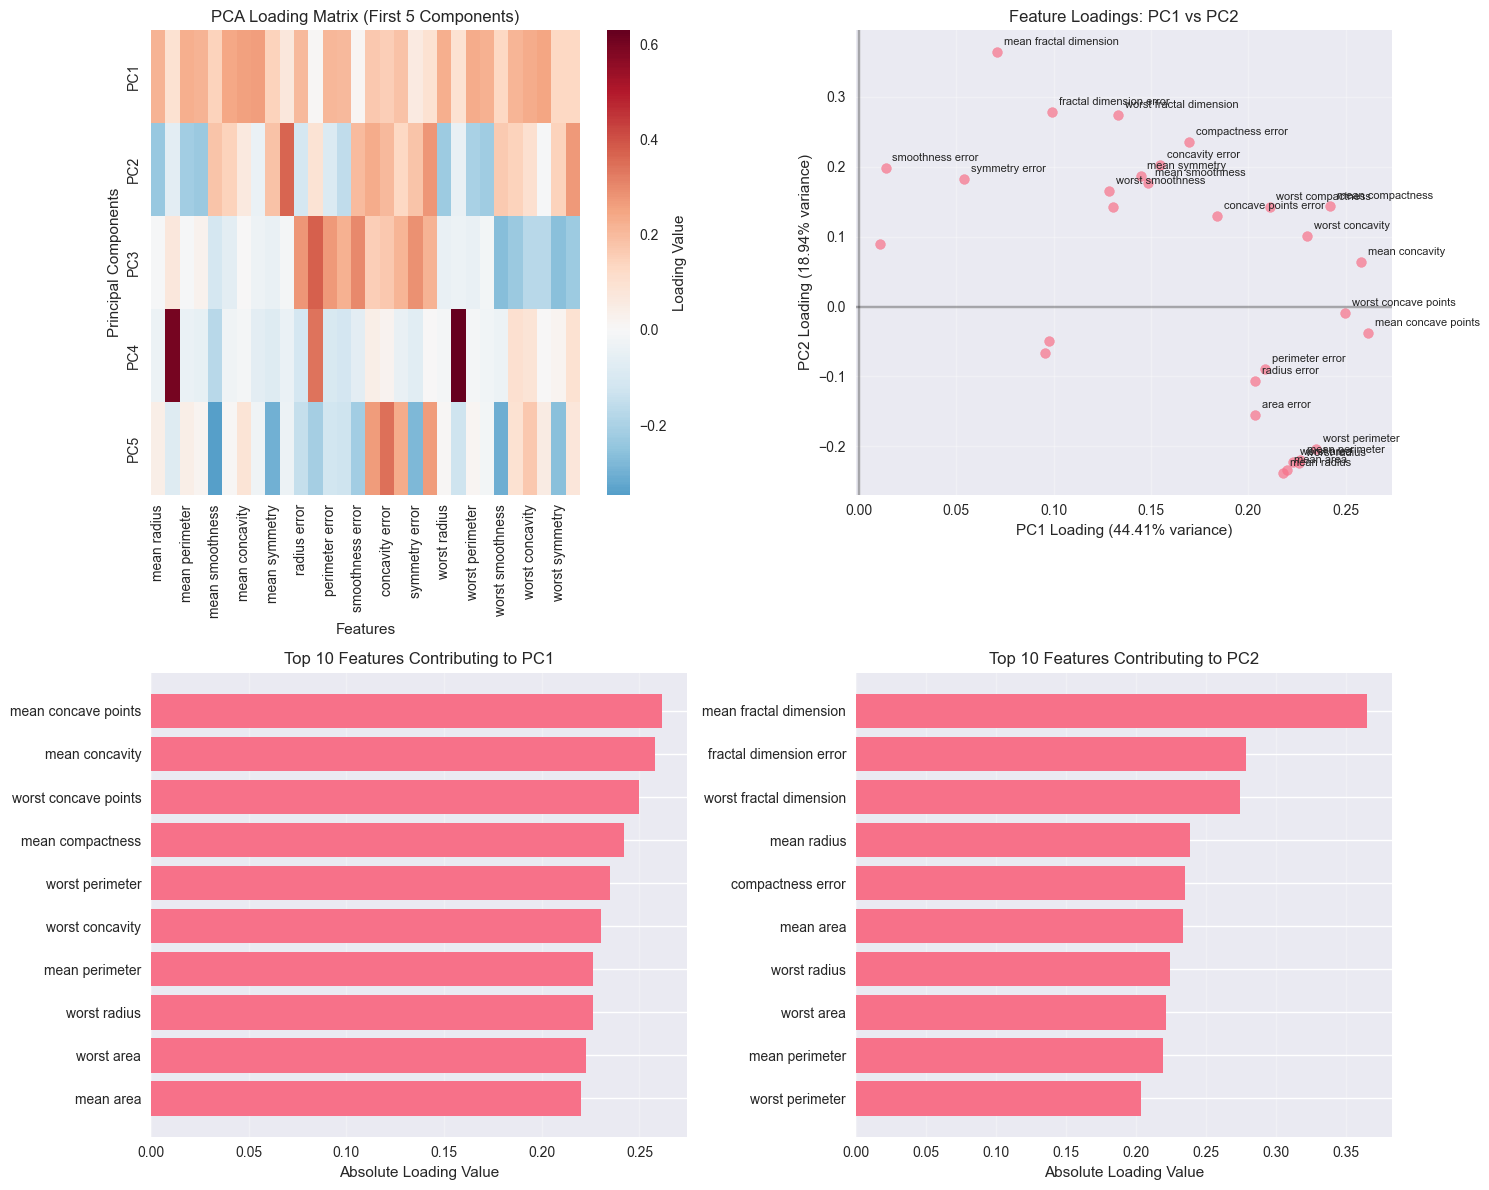

Principal Component Analysis - Feature Loadings:

Principal Component 1 (Explains 0.4441 variance):
Top 5 contributing features:
  1. mean concave points: 0.2614 (|0.2614|)
  2. mean concavity: 0.2578 (|0.2578|)
  3. worst concave points: 0.2499 (|0.2499|)
  4. mean compactness: 0.2422 (|0.2422|)
  5. worst perimeter: 0.2349 (|0.2349|)

Principal Component 2 (Explains 0.1894 variance):
Top 5 contributing features:
  1. mean fractal dimension: 0.3646 (|0.3646|)
  2. fractal dimension error: 0.2783 (|0.2783|)
  3. worst fractal dimension: 0.2741 (|0.2741|)
  4. mean radius: -0.2387 (|0.2387|)
  5. compactness error: 0.2348 (|0.2348|)

Principal Component 3 (Explains 0.0954 variance):
Top 5 contributing features:
  1. texture error: 0.3765 (|0.3765|)
  2. smoothness error: 0.3034 (|0.3034|)
  3. symmetry error: 0.2886 (|0.2886|)
  4. radius error: 0.2775 (|0.2775|)
  5. perimeter error: 0.2744 (|0.2744|)

Principal Component 4 (Explains 0.0672 variance):
Top 5 contributing features:
  1. 

In [15]:
# Detailed feature loading analysis
pca_5 = PCA(n_components=5)
pca_5.fit(X_train_scaled)

# Create loading matrix
loading_matrix = pca_5.components_.T
loading_df = pd.DataFrame(loading_matrix, 
                         index=data.feature_names,
                         columns=[f'PC{i+1}' for i in range(5)])

# Visualize loadings
plt.figure(figsize=(15, 12))

# Heatmap of loadings
plt.subplot(2, 2, 1)
sns.heatmap(loading_df.T, cmap='RdBu_r', center=0, 
            annot=False, cbar_kws={'label': 'Loading Value'})
plt.title('PCA Loading Matrix (First 5 Components)')
plt.xlabel('Features')
plt.ylabel('Principal Components')

# Loading plot for PC1 vs PC2
plt.subplot(2, 2, 2)
plt.scatter(loading_df['PC1'], loading_df['PC2'], alpha=0.7, s=50)

# Annotate some points
for i, feature in enumerate(data.feature_names):
    if abs(loading_df.iloc[i]['PC1']) > 0.15 or abs(loading_df.iloc[i]['PC2']) > 0.15:
        plt.annotate(feature, (loading_df.iloc[i]['PC1'], loading_df.iloc[i]['PC2']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.xlabel(f'PC1 Loading ({pca_5.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 Loading ({pca_5.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Feature Loadings: PC1 vs PC2')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Top contributing features for each PC
plt.subplot(2, 2, 3)
pc1_contributions = np.abs(loading_df['PC1']).sort_values(ascending=True)[-10:]
plt.barh(range(len(pc1_contributions)), pc1_contributions.values)
plt.yticks(range(len(pc1_contributions)), pc1_contributions.index)
plt.xlabel('Absolute Loading Value')
plt.title('Top 10 Features Contributing to PC1')
plt.grid(axis='x', alpha=0.3)

plt.subplot(2, 2, 4)
pc2_contributions = np.abs(loading_df['PC2']).sort_values(ascending=True)[-10:]
plt.barh(range(len(pc2_contributions)), pc2_contributions.values)
plt.yticks(range(len(pc2_contributions)), pc2_contributions.index)
plt.xlabel('Absolute Loading Value')
plt.title('Top 10 Features Contributing to PC2')
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed loading information
print("Principal Component Analysis - Feature Loadings:")
print("=" * 80)
for pc in range(5):
    print(f"\nPrincipal Component {pc+1} (Explains {pca_5.explained_variance_ratio_[pc]:.4f} variance):")
    pc_loadings = loading_df[f'PC{pc+1}'].abs().sort_values(ascending=False)
    print("Top 5 contributing features:")
    for i, (feature, loading) in enumerate(pc_loadings.head().items()):
        original_loading = loading_df.loc[feature, f'PC{pc+1}']
        print(f"  {i+1}. {feature}: {original_loading:.4f} (|{loading:.4f}|)")

# Feature group analysis
print("\n" + "=" * 80)
print("Feature Group Analysis:")
mean_features = [f for f in data.feature_names if 'mean' in f]
error_features = [f for f in data.feature_names if 'error' in f]
worst_features = [f for f in data.feature_names if 'worst' in f]

for pc in range(3):  # First 3 PCs
    print(f"\nPC{pc+1} - Feature Group Contributions:")
    
    mean_contrib = loading_df.loc[mean_features, f'PC{pc+1}'].abs().mean()
    error_contrib = loading_df.loc[error_features, f'PC{pc+1}'].abs().mean()
    worst_contrib = loading_df.loc[worst_features, f'PC{pc+1}'].abs().mean()
    
    print(f"  Mean features: {mean_contrib:.4f}")
    print(f"  Error features: {error_contrib:.4f}")
    print(f"  Worst features: {worst_contrib:.4f}")
    
    # Determine dominant group
    contributions = {'Mean': mean_contrib, 'Error': error_contrib, 'Worst': worst_contrib}
    dominant_group = max(contributions, key=contributions.get)
    print(f"  Dominant group: {dominant_group}")

## 8. Reconstruction Error Analysis

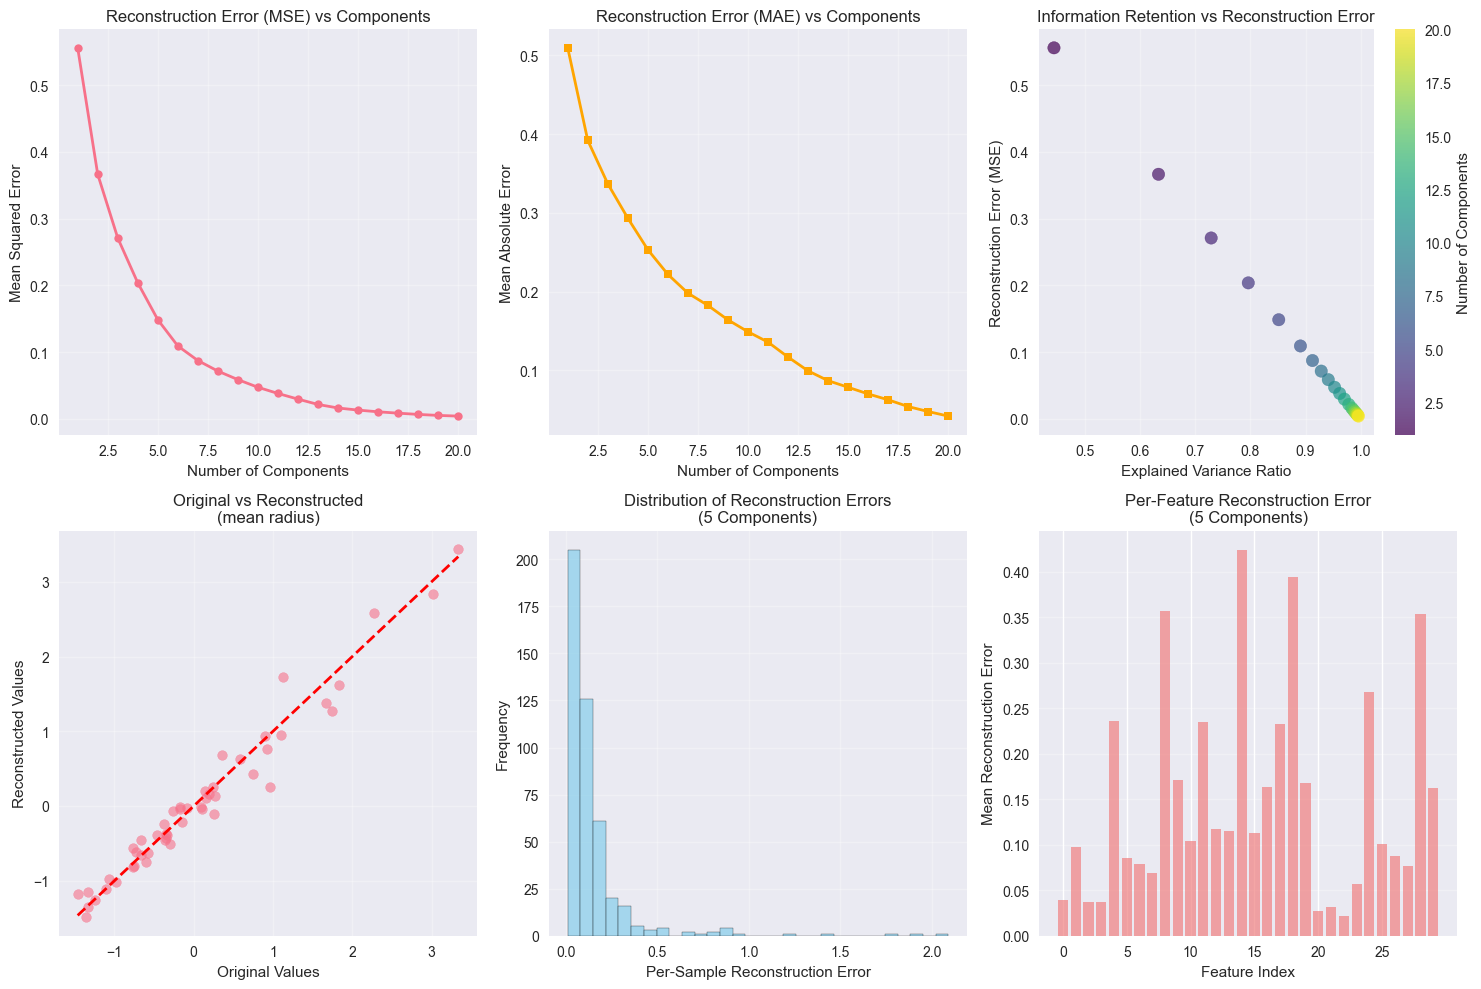

Reconstruction Error Analysis:
Using 5 components:
  Explained variance: 0.8514
  Mean Squared Error: 0.148562
  Mean Absolute Error: 0.253158
  Information retained: 85.14%

Reconstruction quality by number of components:
Components   Explained Var   MSE          MAE         
------------------------------------------------------------
2            0.6336          0.366419     0.391915    
5            0.8514          0.148562     0.253158    
10           0.9527          0.047323     0.149015    
15           0.9868          0.013159     0.078572    

Optimal components analysis:
Largest improvement (1st derivative): Component 2
Elbow point (2nd derivative): Component 18
Components for 95% variance retention: 10


In [16]:
# Reconstruction error analysis
def calculate_reconstruction_error(X, n_components):
    """Calculate reconstruction error for given number of components"""
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    X_reconstructed = pca.inverse_transform(X_pca)
    
    # Mean squared error
    mse = np.mean((X - X_reconstructed) ** 2)
    # Mean absolute error
    mae = np.mean(np.abs(X - X_reconstructed))
    
    return mse, mae, X_reconstructed

# Test reconstruction error for different number of components
component_range_recon = range(1, 21)
mse_errors = []
mae_errors = []

for n_comp in component_range_recon:
    mse, mae, _ = calculate_reconstruction_error(X_train_scaled, n_comp)
    mse_errors.append(mse)
    mae_errors.append(mae)

# Visualize reconstruction error
plt.figure(figsize=(15, 10))

# Reconstruction error vs components
plt.subplot(2, 3, 1)
plt.plot(component_range_recon, mse_errors, 'o-', linewidth=2, markersize=6)
plt.xlabel('Number of Components')
plt.ylabel('Mean Squared Error')
plt.title('Reconstruction Error (MSE) vs Components')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.plot(component_range_recon, mae_errors, 's-', color='orange', linewidth=2, markersize=6)
plt.xlabel('Number of Components')
plt.ylabel('Mean Absolute Error')
plt.title('Reconstruction Error (MAE) vs Components')
plt.grid(True, alpha=0.3)

# Information retention vs error trade-off
plt.subplot(2, 3, 3)
explained_vars = [PCA(n_components=n).fit(X_train_scaled).explained_variance_ratio_.sum() 
                 for n in component_range_recon]
plt.scatter(explained_vars, mse_errors, c=list(component_range_recon), 
           cmap='viridis', s=80, alpha=0.7)
plt.colorbar(label='Number of Components')
plt.xlabel('Explained Variance Ratio')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Information Retention vs Reconstruction Error')
plt.grid(True, alpha=0.3)

# Original vs reconstructed comparison (using 5 components)
mse_5, mae_5, X_reconstructed_5 = calculate_reconstruction_error(X_train_scaled, 5)

# Select a few features for comparison
sample_features = [0, 1, 2, 3, 4]  # First 5 features
sample_size = 50  # First 50 samples

plt.subplot(2, 3, 4)
original_sample = X_train_scaled[:sample_size, sample_features[0]]
reconstructed_sample = X_reconstructed_5[:sample_size, sample_features[0]]

plt.scatter(original_sample, reconstructed_sample, alpha=0.6)
plt.plot([original_sample.min(), original_sample.max()], 
         [original_sample.min(), original_sample.max()], 'r--', linewidth=2)
plt.xlabel('Original Values')
plt.ylabel('Reconstructed Values')
plt.title(f'Original vs Reconstructed\n({data.feature_names[sample_features[0]]})')
plt.grid(True, alpha=0.3)

# Error distribution
plt.subplot(2, 3, 5)
reconstruction_errors = np.mean((X_train_scaled - X_reconstructed_5) ** 2, axis=1)
plt.hist(reconstruction_errors, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Per-Sample Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors\n(5 Components)')
plt.grid(True, alpha=0.3)

# Feature-wise reconstruction error
plt.subplot(2, 3, 6)
feature_errors = np.mean((X_train_scaled - X_reconstructed_5) ** 2, axis=0)
feature_names_short = [name.split()[-1] for name in data.feature_names]

plt.bar(range(len(feature_errors)), feature_errors, alpha=0.7, color='lightcoral')
plt.xlabel('Feature Index')
plt.ylabel('Mean Reconstruction Error')
plt.title('Per-Feature Reconstruction Error\n(5 Components)')
plt.xticks(range(0, len(feature_errors), 5), range(0, len(feature_errors), 5))
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print reconstruction statistics
print("Reconstruction Error Analysis:")
print("=" * 60)
print(f"Using 5 components:")
print(f"  Explained variance: {PCA(5).fit(X_train_scaled).explained_variance_ratio_.sum():.4f}")
print(f"  Mean Squared Error: {mse_5:.6f}")
print(f"  Mean Absolute Error: {mae_5:.6f}")
print(f"  Information retained: {(1 - mse_5) * 100:.2f}%")

print(f"\nReconstruction quality by number of components:")
print(f"{'Components':<12} {'Explained Var':<15} {'MSE':<12} {'MAE':<12}")
print("-" * 60)
for i, n_comp in enumerate([2, 5, 10, 15]):
    if n_comp <= len(component_range_recon):
        idx = n_comp - 1
        exp_var = PCA(n_comp).fit(X_train_scaled).explained_variance_ratio_.sum()
        print(f"{n_comp:<12} {exp_var:<15.4f} {mse_errors[idx]:<12.6f} {mae_errors[idx]:<12.6f}")

# Find optimal number of components (elbow method for reconstruction error)
# Calculate rate of change in MSE
mse_diff = np.diff(mse_errors)
mse_diff2 = np.diff(mse_diff)  # Second derivative

print(f"\nOptimal components analysis:")
print(f"Largest improvement (1st derivative): Component {np.argmax(-mse_diff) + 2}")
print(f"Elbow point (2nd derivative): Component {np.argmax(-mse_diff2) + 3}")

# Recommend based on 95% variance retention
optimal_components = np.argmax(np.array(explained_vars) >= 0.95) + 1
print(f"Components for 95% variance retention: {optimal_components}")

## 9. Summary and Conclusions

In [17]:
# Comprehensive PCA summary
print("=== PRINCIPAL COMPONENT ANALYSIS ON BREAST CANCER DATASET ===")
print()

# Dataset summary
print("Dataset Summary:")
print(f"• Original dimensions: {X.shape}")
print(f"• Classes: {data.target_names}")
print(f"• Features: 30 numerical features (mean, error, worst values)")
print(f"• Class distribution: Malignant={np.sum(y==0)}, Benign={np.sum(y==1)}")
print()

# PCA findings
pca_summary = PCA().fit(X_train_scaled)
print("PCA Analysis Results:")
print(f"• First 2 components explain: {pca_summary.explained_variance_ratio_[:2].sum():.4f} of variance")
print(f"• First 5 components explain: {pca_summary.explained_variance_ratio_[:5].sum():.4f} of variance")
print(f"• First 10 components explain: {pca_summary.explained_variance_ratio_[:10].sum():.4f} of variance")

# Find components for different variance thresholds
for threshold in [0.8, 0.9, 0.95]:
    n_comp = np.argmax(np.cumsum(pca_summary.explained_variance_ratio_) >= threshold) + 1
    print(f"• {n_comp} components needed for {threshold*100}% variance retention")
print()

# Classification performance summary
print("Classification Performance Summary:")
print(f"• Baseline (30 features): {baseline_accuracy:.4f} accuracy")

# Find best performing configurations
best_lr_idx = np.argmax(lr_results['accuracy'])
best_lr_comp = lr_results['n_components'][best_lr_idx]
best_lr_acc = lr_results['accuracy'][best_lr_idx]
best_lr_var = lr_results['explained_variance'][best_lr_idx]

print(f"• Best PCA performance: {best_lr_comp} components")
print(f"  - Accuracy: {best_lr_acc:.4f}")
print(f"  - Explained variance: {best_lr_var:.4f}")
print(f"  - Dimensionality reduction: {(30-best_lr_comp)/30*100:.1f}%")

# Efficiency analysis
efficient_configs = []
for i, (n_comp, acc, var) in enumerate(zip(lr_results['n_components'], 
                                          lr_results['accuracy'], 
                                          lr_results['explained_variance'])):
    efficiency = acc / (n_comp / 30)  # Accuracy per dimensionality ratio
    if acc >= baseline_accuracy * 0.95:  # Within 5% of baseline
        efficient_configs.append((n_comp, acc, var, efficiency))

if efficient_configs:
    best_efficient = max(efficient_configs, key=lambda x: x[3])
    print(f"• Most efficient configuration: {best_efficient[0]} components")
    print(f"  - Accuracy: {best_efficient[1]:.4f} (retains {best_efficient[1]/baseline_accuracy*100:.1f}% of baseline)")
    print(f"  - Explained variance: {best_efficient[2]:.4f}")
    print(f"  - Efficiency score: {best_efficient[3]:.2f}")
print()

# Feature interpretation
print("Feature Analysis:")
pca_interp = PCA(n_components=3).fit(X_train_scaled)
for pc in range(3):
    top_features_idx = np.argsort(np.abs(pca_interp.components_[pc]))[-3:]
    top_features = [data.feature_names[i] for i in top_features_idx]
    print(f"• PC{pc+1} ({pca_interp.explained_variance_ratio_[pc]:.3f} variance) main features:")
    print(f"  {', '.join(top_features)}")
print()

# Practical recommendations
print("Practical Recommendations:")
print("1. For maximum accuracy: Use all 30 features (baseline)")
print(f"2. For balanced performance: Use {best_lr_comp} components ({best_lr_var:.1%} variance, {best_lr_acc:.4f} accuracy)")

# Find minimal components with good performance
min_good_comp = None
for i, acc in enumerate(lr_results['accuracy']):
    if acc >= baseline_accuracy * 0.95:  # Within 5% of baseline
        min_good_comp = lr_results['n_components'][i]
        break

if min_good_comp:
    min_good_idx = lr_results['n_components'].index(min_good_comp)
    print(f"3. For dimensionality reduction: Use {min_good_comp} components")
    print(f"   - {(30-min_good_comp)/30*100:.1f}% reduction, {lr_results['explained_variance'][min_good_idx]:.1%} variance")
    print(f"   - {lr_results['accuracy'][min_good_idx]:.4f} accuracy ({lr_results['accuracy'][min_good_idx]/baseline_accuracy*100:.1f}% of baseline)")

print("4. For visualization: Use 2-3 components for interpretable plots")
print()

# Technical insights
print("Technical Insights:")
print("• PCA effectively captures the main variance in breast cancer features")
print("• Strong correlation between morphological features enables good dimensionality reduction")
print("• First few components capture size/shape information (radius, area, perimeter)")
print("• Later components capture texture and geometric properties")
print("• Reconstruction error decreases rapidly with first 10 components")
print("• Feature groups (mean, error, worst) contribute differently to each PC")
print()

print("Conclusion:")
print("PCA demonstrates excellent dimensionality reduction capabilities on the breast cancer")
print("dataset, maintaining classification performance while significantly reducing feature space.")
print(f"A reduction from 30 to {best_lr_comp} features retains {best_lr_var:.1%} of information")
print(f"and achieves {best_lr_acc:.4f} accuracy, making it highly suitable for this medical dataset.")

=== PRINCIPAL COMPONENT ANALYSIS ON BREAST CANCER DATASET ===

Dataset Summary:
• Original dimensions: (569, 30)
• Classes: ['malignant' 'benign']
• Features: 30 numerical features (mean, error, worst values)
• Class distribution: Malignant=212, Benign=357

PCA Analysis Results:
• First 2 components explain: 0.6336 of variance
• First 5 components explain: 0.8514 of variance
• First 10 components explain: 0.9527 of variance
• 5 components needed for 80.0% variance retention
• 7 components needed for 90.0% variance retention
• 10 components needed for 95.0% variance retention

Classification Performance Summary:
• Baseline (30 features): 0.9825 accuracy
• Best PCA performance: 20 components
  - Accuracy: 0.9825
  - Explained variance: 0.9958
  - Dimensionality reduction: 33.3%
• Most efficient configuration: 2 components
  - Accuracy: 0.9474 (retains 96.4% of baseline)
  - Explained variance: 0.6336
  - Efficiency score: 14.21

Feature Analysis:
• PC1 (0.444 variance) main features:
  w